In [1]:
!ls /kaggle/input/cow-pin-classification/label/all

Padded	Sharp  Smooth


In [2]:
TRAIN = '/kaggle/input/cow-pin-classification/label/all'

We want to use image embeddings for EDA and classification, so let's add some code that will get them from ResNeXt without fine-tuning.

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 125MB/s]


Let's load up our data, including image embeddings and thumbnails.

In [4]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) if input_file.lower().endswith('jpg')]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') }
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 57 rows of Padded  in 0:00:14.725820
encoded 106 rows of Smooth  in 0:00:27.124365
encoded 78 rows of Sharp  in 0:00:25.201416
done in 0:01:07.085489


We don't have much data, and our classes are unbalanced. How unbalanced are they?

In [5]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag,Smooth,Sharp,Padded
proportion,0.439834,0.323651,0.236515


We have roughly twice as many smooth as padded, and sharp is somewhere in between. Let's add some x/y coordinates based on our image embeddings.

In [6]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 241 samples in 0.003s...
[t-SNE] Computed neighbors for 241 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 241 / 241
[t-SNE] Mean sigma: 3.954447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.502007
[t-SNE] KL divergence after 1000 iterations: 0.958281


Now we're ready to plot.

In [7]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=min(5000, len(train_df)-1), random_state=2025))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: cow pins', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=6, color=mapper)
show(plot_figure)

Loading BokehJS ...

WHat do we see? Apart from what appears to be some local clustering in the smooth class, this data looks random. We should expect poor accuracy from our model. Let's build a model and find out the bad news.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 214 iterations
accuracy: 0.3607
f1: 0.3580
              precision    recall  f1-score   support

      Padded       0.40      0.29      0.33        14
       Sharp       0.36      0.45      0.40        20
      Smooth       0.35      0.33      0.34        27

    accuracy                           0.36        61
   macro avg       0.37      0.36      0.36        61
weighted avg       0.36      0.36      0.36        61



Our data is essentially random, so our model has lower accuracy than a model that always guesses the largest class.

In [9]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent', random_state=2025).fit(X_train, y_train)
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=dummy.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=dummy.predict(X=X_test))))
print(classification_report(zero_division=0.0, y_true=y_test, y_pred=dummy.predict(X=X_test)))

accuracy: 0.4426
f1: 0.2716
              precision    recall  f1-score   support

      Padded       0.00      0.00      0.00        14
       Sharp       0.00      0.00      0.00        20
      Smooth       0.44      1.00      0.61        27

    accuracy                           0.44        61
   macro avg       0.15      0.33      0.20        61
weighted avg       0.20      0.44      0.27        61



As expected our accuracy is higher with a dummy model, but our f1 is lower than logistic regression.

Let's take a look at our logistic regression model probabilities.

<Axes: xlabel='probability', ylabel='Count'>

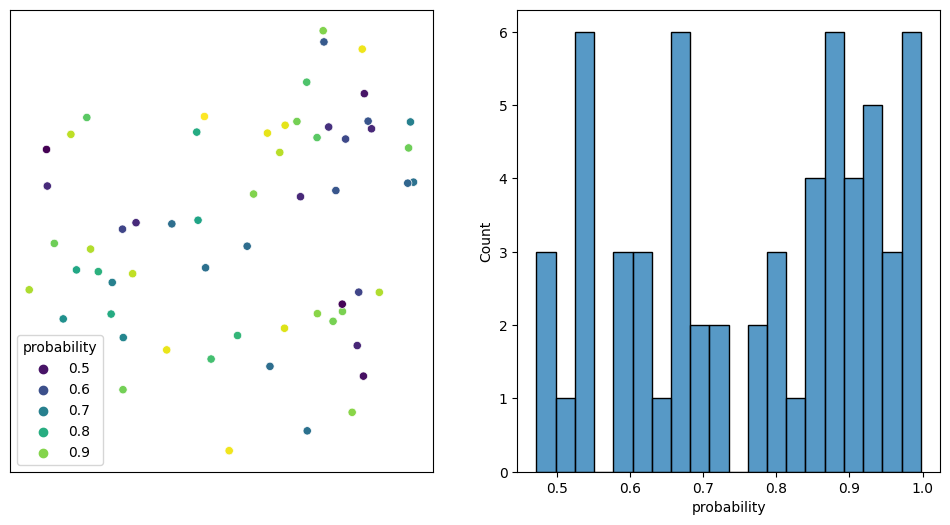

In [10]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Our model probabilities look essentially random, too.